In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
df_transaction = pd.read_csv('Case_Study_Transaction.csv', sep = ';')
df_customer = pd.read_csv('Case_Study_Customer.csv', sep = ';')
df_store = pd.read_csv('Case_Study_Store.csv', sep = ';')
df_product = pd.read_csv('Case_Study_Product.csv', sep = ';')

In [8]:
df_customer['Income'] = df_customer['Income'].replace('[,]','.',regex=True)

In [10]:
df_store['Latitude'] = df_store['Latitude'].replace('[,]','.',regex=True)
df_store['Longitude'] = df_store['Longitude'].replace('[,]','.',regex=True)

In [12]:
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'],format='mixed')

In [14]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [16]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,44,1,Married,14.58,Yoghurt,Prima Tendean,Prima,Modern Trade,-6.2,106.816666
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,27,1,Single,0.18,Choco Bar,Gita Ginara,Gita,General Trade,-6.966667,110.416664
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,48,1,Married,12.57,Choco Bar,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,33,0,Married,6.95,Yoghurt,Gita Ginara,Gita,General Trade,-6.966667,110.416664


In [18]:
df_regresi = df_merge.groupby(['Date']).agg({
 'Qty' : 'sum'
}).reset_index()

In [20]:
df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


In [22]:
split_index = int(len(df_regresi) * 0.8)
df_train = df_regresi.iloc[:split_index].copy()
df_test = df_regresi.iloc[split_index:].copy()

In [24]:
def eval(y_true, y_pred):
 mae = mean_absolute_error(y_true, y_pred)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA par

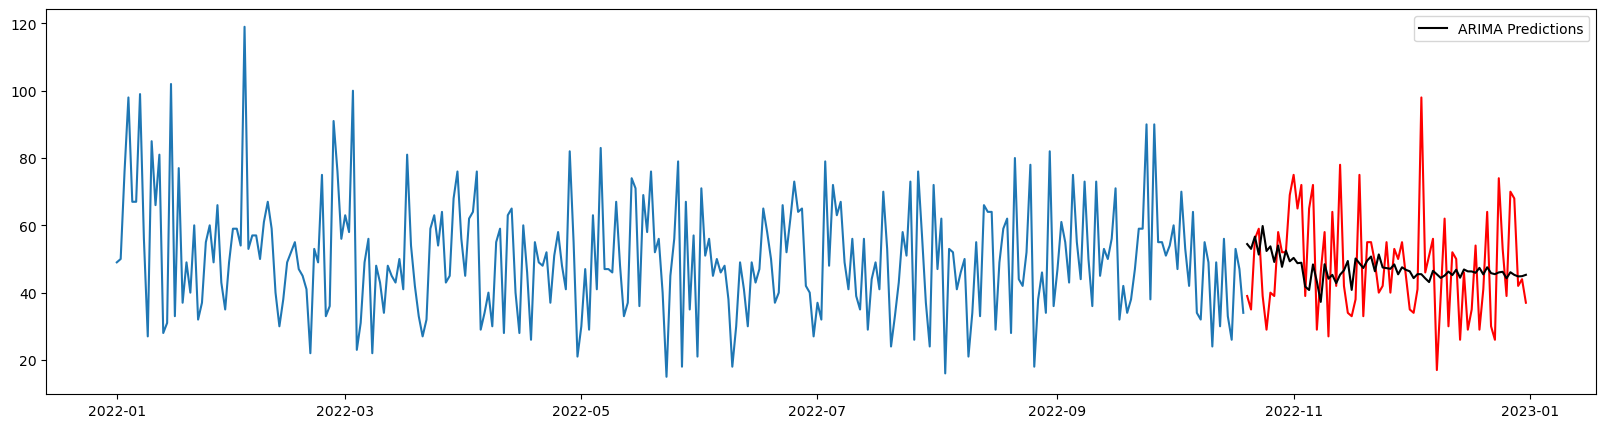

In [26]:
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']

ARIMAmodel = ARIMA(y, order = (40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))
y_pred_df = y_pred.conf_int()
y_pred_df ['predictions'] = ARIMAmodel. predict(start =y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df. index = df_test. index
y_pred_out = y_pred_df ['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20,5))
plt.plot(df_train['Qty'])
plt.plot (df_test['Qty'], color='red' )
plt.plot(y_pred_out, color='black', label = 'ARIMA Predictions')
plt.legend ()